In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import scipy.stats
import astropy.coordinates as coord
import astropy.constants as consts
import cosmolopy.distance as cd
import pathos.multiprocessing
import math

from astropy.io import fits

cosmo = {u'h': 0.688, u'omega_lambda_0': 0.705, u'omega_k_0': 0.0, u'omega_M_0': 0.295}
cd.set_omega_k_0(cosmo)

{u'h': 0.688, u'omega_M_0': 0.295, u'omega_k_0': 0.0, u'omega_lambda_0': 0.705}

In [2]:
def classify(M_sol, RA, DEC, Z, MAG, min_z, max_z, masscut):
    flag = False
    if math.isnan(M_sol) == True:
        return False
    if not M_sol > 0:
        return False
        
    if masscut <= np.log10(M_sol) <= 20:
        pass
    else:
        return False
    
    if (100 < RA < 300) != True:
        return False
    
    if min_z <= Z <= max_z:
        pass
    else:
        return False
        
    if math.isinf(MAG):
        return False

    return True

In [3]:
survey = fits.open('../BAM/Old/nsa_v1.fits')[1].data
mass_survey = survey['SERSIC_MASS']/cosmo['h']**2
RA_survey = survey['RA']
DEC_survey = survey['DEC']
Z_survey = survey['ZDIST']
MAG_survey = survey['SERSIC_ABSMAG']

MAG_r = MAG_survey[:, 4]

Plot the NSA data without any cuts

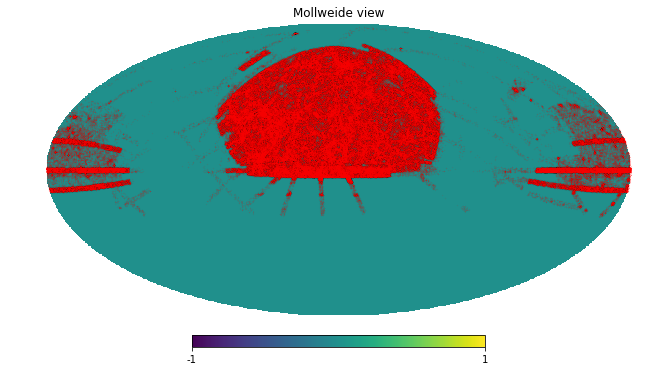

In [14]:
hp.mollview(np.zeros(12), rot=[180, 0, 0])
hp.projscatter(np.pi/2-np.deg2rad(DEC_survey), np.deg2rad(RA_survey), s=0.001, c='red')
plt.savefig("../Plots/Fig1_AllNSAdata")

Here the plot below: picks out some pixels.. Only in those pixels will accept random galaxies. Trying to pick out the central region

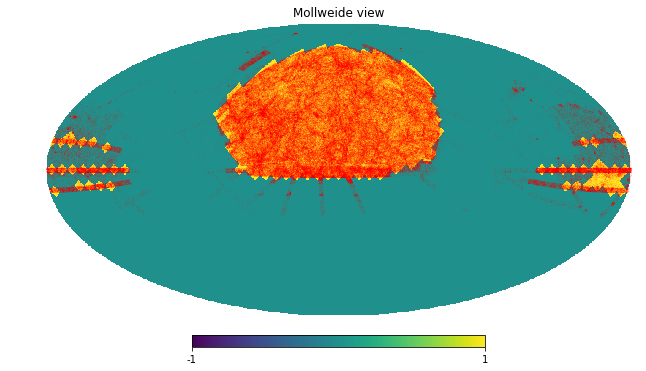

In [15]:
nside=14
pix_count = np.zeros(hp.nside2npix(nside))

for r, d in zip(np.deg2rad(RA_survey), np.deg2rad(DEC_survey)):
    pix = hp.ang2pix(nside, np.pi/2-d, r)
    pix_count[pix] += 1

#Get a list of pixels in which there are galaxies
active_pixels = np.zeros(hp.nside2npix(nside))
pixs_list = list()
for i in range(pix_count.size):
    if pix_count[i] > 650:
        pixs_list.append(i)
        active_pixels[i] = 1

for i in range(active_pixels.size):
    ngbh = hp.get_all_neighbours(nside, i)
    count = 0
    for ng in ngbh:
        if (ng in pixs_list) == False:
            count += 1
    if count <= 3:
        active_pixels[i] = 1
        pixs_list.append(i)



hp.mollview(active_pixels, rot=[180, 0, 0], min=-1, max=1)
hp.projscatter(np.pi/2-np.deg2rad(DEC_survey), np.deg2rad(RA_survey),
               s=0.001, c='red', alpha=0.45)
plt.savefig("../Plots/Fig2_ActivePixels.png")

Here set the cuts and make sure only galaxies in the "active pixels" considered

In [6]:
IDS = list()

for m, r, d, rs, mag, i in zip(mass_survey, RA_survey,
                          DEC_survey, Z_survey, MAG_r, np.arange(mass_survey.size)):
    if (i%100000)==0:
            print(i)
    if classify(m, r, d, rs, mag,
                min_z=0.005, max_z=0.064, masscut=9.8) == True:
        IDS.append(i)
        
IDS = np.array(IDS)

RA = RA_survey[IDS]
DEC = DEC_survey[IDS]
Dist = Z_survey[IDS]*consts.c.to_value('km/s')/(cosmo['h']*100)

IDS = list()
for r, d, i in zip(RA, DEC, np.arange(RA.size)):
    px = hp.ang2pix(nside, np.pi/2-np.deg2rad(d), np.deg2rad(r))
    if (px in pixs_list) == False:
        IDS.append(i)

RA = np.delete(RA, IDS)
DEC = np.delete(DEC, IDS)
Dist = np.delete(Dist, IDS)
        


N = RA.size

cut_survey = np.zeros(N, dtype={'names':('ra', 'dec', 'dist'),
                          'formats':('float64', 'float64', 'float64')})
cut_survey['ra'] = np.ravel(RA)
cut_survey['dec'] = np.ravel(DEC)
cut_survey['dist'] = np.ravel(Dist)


np.save('../Data/sdss_cutoff.npy', cut_survey)
print(N)

0
100000
200000
300000
400000
500000
600000
88688


Make a plot of the cut

Check if active pixels are in some RA range

In [19]:
IDS = list()
for px, i in zip(pixs_list, np.arange(len(pixs_list))):
    theta, phi = hp.pix2ang(nside, px)
    phi = np.rad2deg(phi)
    if (100 < phi < 300) == False:
#         print('a')
        IDS.append(i)

pixs_list = np.array(pixs_list)
pixs_list = np.delete(pixs_list, IDS)
pixs_list = pixs_list.tolist()
                 

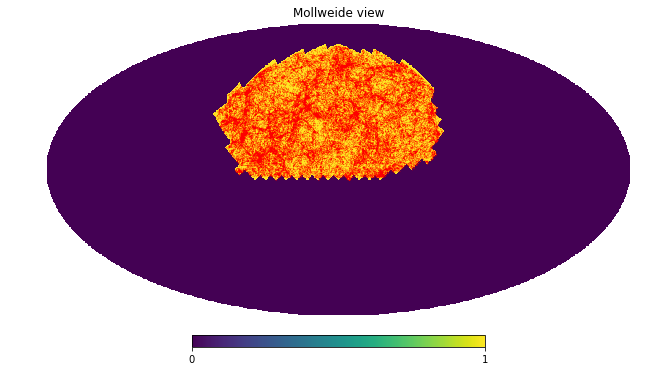

In [22]:
m = np.zeros(hp.nside2npix(nside))
m[pixs_list] = 1
hp.mollview(m, rot=[180, 0, 0])
hp.projscatter(np.pi/2-np.deg2rad(DEC), np.deg2rad(RA),
               s=0.005, c='red')
plt.savefig("../Plots/NSAafterCutsFinal")

In [10]:
# Start generating random catalog
N_pools = 8
min_dist = np.min(Dist)
max_dist = np.max(Dist)
boxsize=max_dist



pool = pathos.multiprocessing.ProcessingPool(N_pools)

def get_galaxy(i):
    while True:
        x, y, z = scipy.stats.uniform.rvs(loc=-1, scale=2, size=3)*boxsize
        pix = hp.vec2pix(nside, x,y,z)

        if pix in pixs_list:
            sim_dist = np.sqrt(x**2+y**2+z**2)
            if min_dist < sim_dist < max_dist:
                theta, phi = hp.vec2ang(np.array([x,y,z]))
                return [np.pi/2-theta, phi, sim_dist]
#                 return [np.pi/2-theta, phi, sim_dist, x, y, z]

Nmax = Dist.size*100
# Nmax = 50000



loop_out = pool.map(get_galaxy, range(Nmax))
rand_DEC = np.array([float(item[0]) for item in loop_out])
rand_RA = np.array([float(item[1]) for item in loop_out])
rand_Dist = np.array([float(item[2]) for item in loop_out])


pool.close()
pool.join()
pool.clear()
    

catalog = np.zeros(Nmax, dtype={'names':('ra', 'dec', 'dist'),
                          'formats':('float64', 'float64', 'float64')})
catalog['ra'] = np.rad2deg(np.ravel(rand_RA))
catalog['dec'] = np.rad2deg(np.ravel(rand_DEC))
catalog['dist'] = np.ravel(rand_Dist)


np.save('../Data/randCat_matchnsa.npy', catalog)

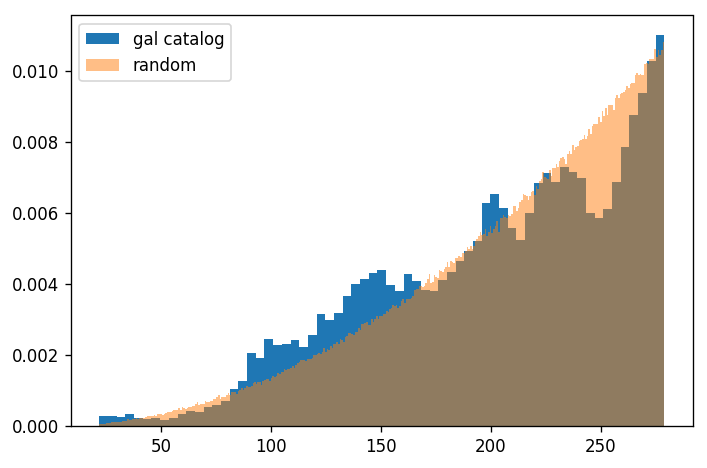

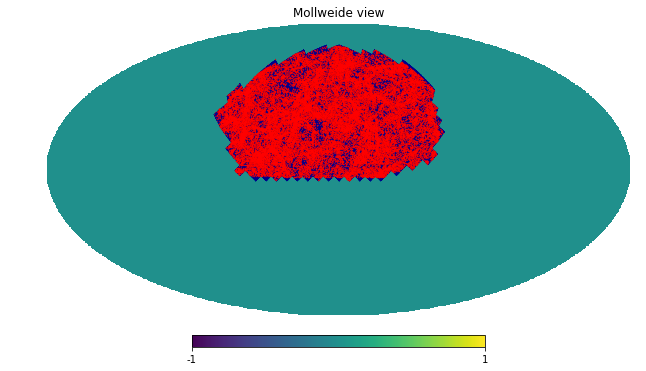

In [25]:
# Make a histogram just to check everything is going according to plan..
plt.figure(dpi=120)
plt.hist(Dist, bins='auto', density=1, label='gal catalog')
plt.hist(rand_Dist, bins='auto', density=1, alpha=0.5, label='random')
plt.legend()
plt.tight_layout()
plt.savefig("../Plots/Fig5_DistHist.pdf")
plt.show()

# And a HealPy map to plot galaxies pos..
hp.mollview(np.zeros(hp.nside2npix(nside)), rot=[180, 0, 0])
hp.projscatter(np.pi/2-rand_DEC, rand_RA, s=0.0001, c='blue', alpha=0.2)
hp.projscatter(np.pi/2-np.deg2rad(DEC), np.deg2rad(RA), s=0.05, c='r')
plt.savefig("../Plots/Fig6_GalandRand")
plt.show()

In [26]:
rand_RA.size

8868800